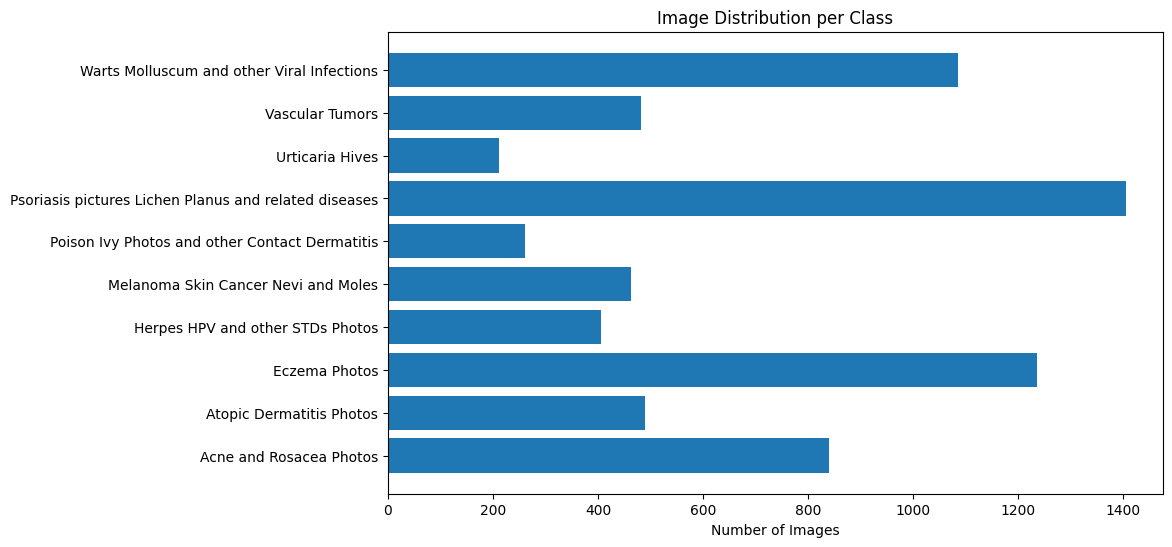

In [3]:
import os
import matplotlib.pyplot as plt

train_folder = "train"
disease_classes = os.listdir(train_folder)
image_count_per_class = [len(os.listdir(os.path.join(train_folder, disease))) for disease in disease_classes]

plt.figure(figsize=(10, 6))
plt.barh(disease_classes, image_count_per_class)
plt.xlabel('Number of Images')
plt.title('Image Distribution per Class')
plt.show()


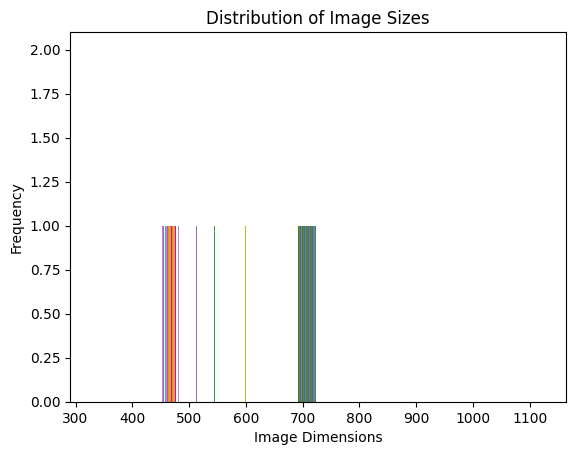

In [4]:
from PIL import Image

image_shapes = []
for disease in disease_classes:
    for img_name in os.listdir(os.path.join(train_folder, disease)):
        img = Image.open(os.path.join(train_folder, disease, img_name))
        image_shapes.append(img.size)

# Plot the distribution of image sizes
plt.hist(image_shapes, bins=20)
plt.xlabel('Image Dimensions')
plt.ylabel('Frequency')
plt.title('Distribution of Image Sizes')
plt.show()


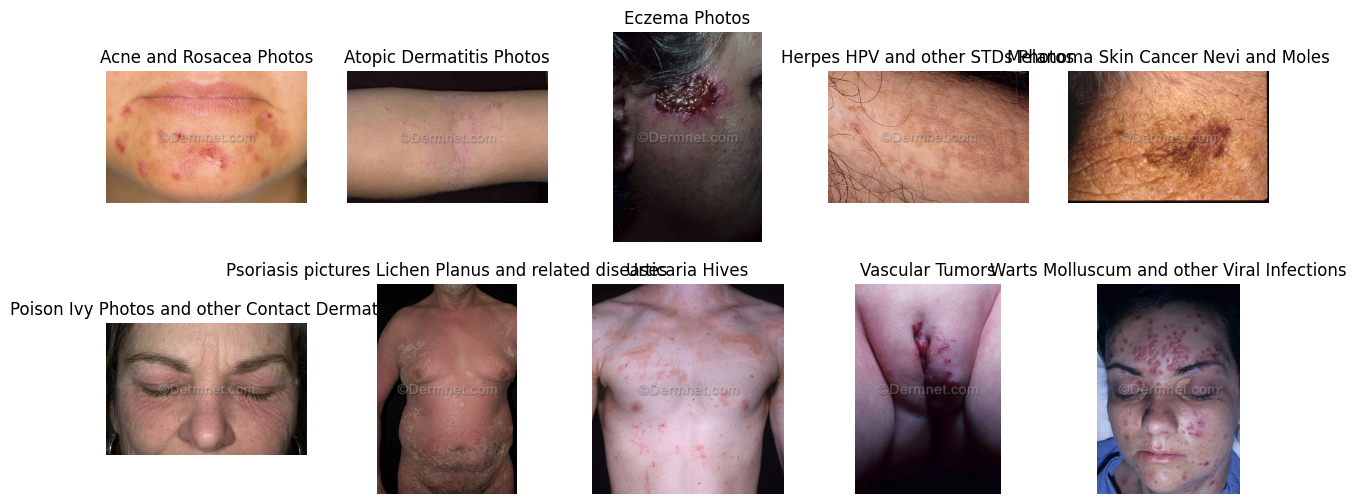

In [5]:
import random
import matplotlib.pyplot as plt
from PIL import Image

def show_sample_images(train_folder, disease_classes):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i, disease in enumerate(disease_classes):
        ax = axes[i//5, i%5]
        img_name = random.choice(os.listdir(os.path.join(train_folder, disease)))
        img_path = os.path.join(train_folder, disease, img_name)
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(disease)
        ax.axis('off')
    plt.show()

show_sample_images(train_folder, disease_classes)


In [6]:
from collections import Counter

class_counts = Counter(image_count_per_class)
print("Class Distribution: ", class_counts)


Class Distribution:  Counter({840: 1, 489: 1, 1235: 1, 405: 1, 463: 1, 260: 1, 1405: 1, 212: 1, 482: 1, 1086: 1})


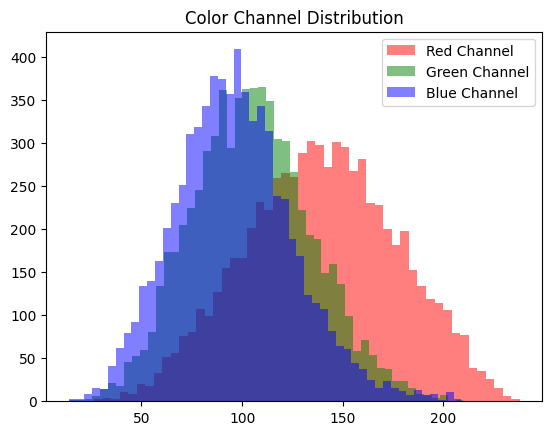

In [7]:
import numpy as np

def analyze_color_distribution(train_folder, disease_classes):
    color_distribution = {'R': [], 'G': [], 'B': []}
    for disease in disease_classes:
        for img_name in os.listdir(os.path.join(train_folder, disease)):
            img = Image.open(os.path.join(train_folder, disease, img_name))
            img_np = np.array(img)
            color_distribution['R'].append(np.mean(img_np[:, :, 0]))
            color_distribution['G'].append(np.mean(img_np[:, :, 1]))
            color_distribution['B'].append(np.mean(img_np[:, :, 2]))
    
    # Plot the distribution for each color channel
    plt.hist(color_distribution['R'], bins=50, color='red', alpha=0.5, label='Red Channel')
    plt.hist(color_distribution['G'], bins=50, color='green', alpha=0.5, label='Green Channel')
    plt.hist(color_distribution['B'], bins=50, color='blue', alpha=0.5, label='Blue Channel')
    plt.legend()
    plt.title('Color Channel Distribution')
    plt.show()

analyze_color_distribution(train_folder, disease_classes)


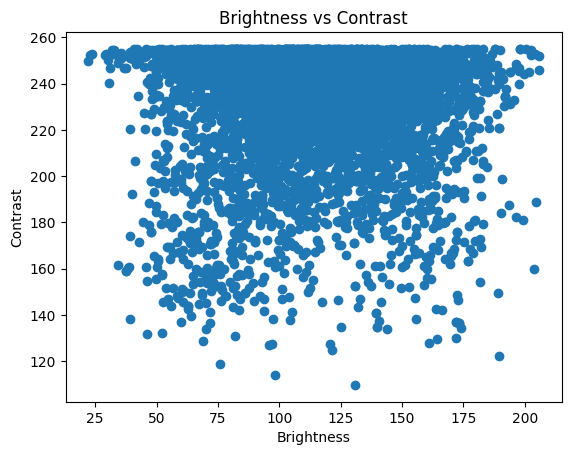

In [8]:
from skimage import exposure

def analyze_brightness_contrast(image):
    gray_img = np.mean(image, axis=2)
    contrast = gray_img.max() - gray_img.min()
    brightness = np.mean(gray_img)
    return brightness, contrast

brightness_contrast = [analyze_brightness_contrast(np.array(Image.open(os.path.join(train_folder, disease, img))))
                       for disease in disease_classes
                       for img in os.listdir(os.path.join(train_folder, disease))]

brightness, contrast = zip(*brightness_contrast)

plt.scatter(brightness, contrast)
plt.xlabel('Brightness')
plt.ylabel('Contrast')
plt.title('Brightness vs Contrast')
plt.show()


In [9]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
from collections import Counter

# Define the directories
train_dir = "train"
test_dir = "test"

# Define the target image size (you can choose a size that works for your model)
IMG_SIZE = (224, 224)

# Number of classes (disease categories)
NUM_CLASSES = 10

# Define a dictionary to map folders to labels
disease_classes = sorted(os.listdir(train_dir))
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(disease_classes)

# Function for Contrast Enhancement and Color Normalization
def preprocess_image(image):
    # Convert to RGB if the image is grayscale
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    # Contrast Enhancement using Histogram Equalization
    image = ImageEnhance.Contrast(image).enhance(1.5)  # Increase contrast by a factor of 1.5
    
    # Convert image to NumPy array and normalize RGB channels
    img_np = np.array(image) / 255.0
    
    # Normalize each color channel to have zero mean and unit variance
    img_mean = np.mean(img_np, axis=(0, 1))
    img_std = np.std(img_np, axis=(0, 1))
    img_normalized = (img_np - img_mean) / img_std
    
    return img_normalized

# Data augmentation including preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255  # Additional rescaling after preprocessing
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    rescale=1./255  # Only rescale the test data
)

# Create generators to load the images in batches
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Optional: Check the class labels mapped by the generator
print("Class labels (disease categories):", train_generator.class_indices)

# Handling Class Imbalance
class_weights = None
train_labels = train_generator.classes  # Get all training labels
class_distribution = Counter(train_labels)  # Get the distribution of classes

# Print the class distribution for analysis
print("Class Distribution:", class_distribution)

# Calculate class weights to handle class imbalance
total_samples = sum(class_distribution.values())
class_weights = {
    i: total_samples / (len(class_distribution) * class_count)
    for i, class_count in class_distribution.items()
}

print("Class Weights:", class_weights)

# Now, when training the model, you can pass these class weights
# to give more importance to underrepresented classes during training.


Found 6877 images belonging to 10 classes.
Found 1743 images belonging to 10 classes.
Class labels (disease categories): {'Acne and Rosacea Photos': 0, 'Atopic Dermatitis Photos': 1, 'Eczema Photos': 2, 'Herpes HPV and other STDs Photos': 3, 'Melanoma Skin Cancer Nevi and Moles': 4, 'Poison Ivy Photos and other Contact Dermatitis': 5, 'Psoriasis pictures Lichen Planus and related diseases': 6, 'Urticaria Hives': 7, 'Vascular Tumors': 8, 'Warts Molluscum and other Viral Infections': 9}
Class Distribution: Counter({6: 1405, 2: 1235, 9: 1086, 0: 840, 1: 489, 8: 482, 4: 463, 3: 405, 5: 260, 7: 212})
Class Weights: {0: 0.8186904761904762, 1: 1.4063394683026584, 2: 0.5568421052631579, 3: 1.6980246913580246, 4: 1.4853131749460042, 5: 2.645, 6: 0.4894661921708185, 7: 3.2438679245283017, 8: 1.4267634854771785, 9: 0.6332412523020258}


Found 6877 images belonging to 10 classes.
Found 1743 images belonging to 10 classes.
Epoch 1/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 359s 2s/step - accuracy: 0.2068 - loss: 2.1325 - val_accuracy: 0.2387 - val_loss: 2.0397 - learning_rate: 0.0010
Epoch 2/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy: 0.2287 - loss: 2.0585 - val_accuracy: 0.2542 - val_loss: 2.0316 - learning_rate: 0.0010
Epoch 3/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.2567 - loss: 2.0349 - val_accuracy: 0.2610 - val_loss: 1.9880 - learning_rate: 0.0010
Epoch 4/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 0.2817 - loss: 1.9663 - val_accuracy: 0.2915 - val_loss: 1.9691 - learning_rate: 0.0010
Epoch 5/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.2942 - loss: 1.9522 - val_accuracy: 0.3001 - val_loss: 1.9258 - learning_rate: 0.0010
Epoch 6/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 365s 2s/step - accuracy: 0.2962 - loss: 1.9356 - val_accuracy: 0.3207 - val_loss: 1.9104 - learning_rate: 0.0

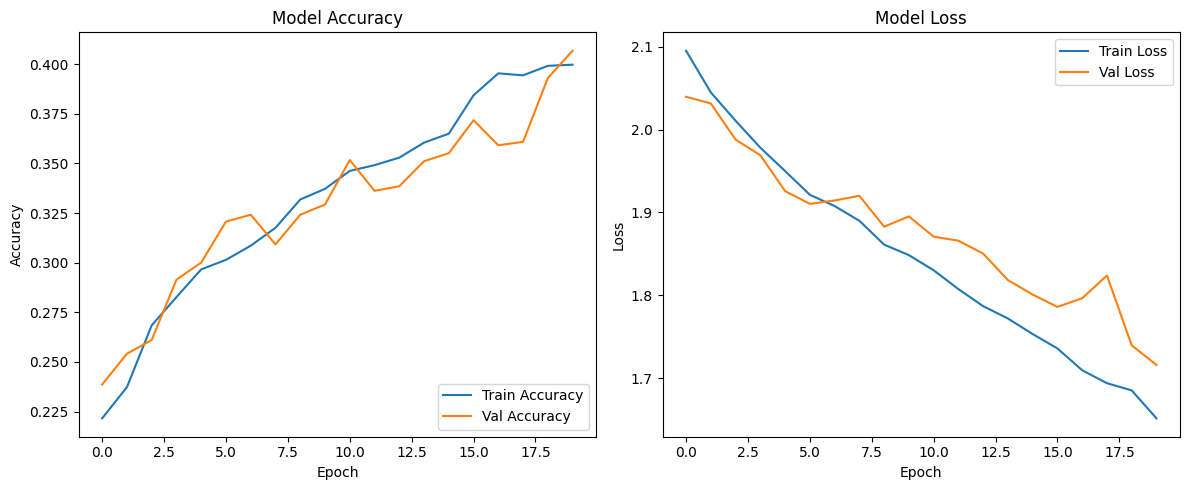

55/55 ━━━━━━━━━━━━━━━━━━━━ 26s 474ms/step - accuracy: 0.4435 - loss: 1.6132
Test Accuracy: 40.68%
Test Loss: 1.7158
55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 232ms/step

Classification Report:
                                                       precision    recall  f1-score   support

                              Acne and Rosacea Photos       0.44      0.62      0.52       230
                             Atopic Dermatitis Photos       0.23      0.07      0.10       123
                                        Eczema Photos       0.50      0.50      0.50       309
                     Herpes HPV and other STDs Photos       0.32      0.12      0.17       102
                  Melanoma Skin Cancer Nevi and Moles       0.50      0.47      0.49       116
       Poison Ivy Photos and other Contact Dermatitis       0.17      0.03      0.05        65
Psoriasis pictures Lichen Planus and related diseases       0.40      0.49      0.44       352
                                      Urticaria Hives    

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

# Define image parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
NUM_CLASSES = 10  # Adjust based on your number of classes

# Create ImageDataGenerator instances with proper preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Setup the generators with proper directory structure
# Replace 'path/to/train' and 'path/to/test' with your actual paths
try:
    train_generator = train_datagen.flow_from_directory(
        'train',
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )

    test_generator = test_datagen.flow_from_directory(
        'test',
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False  # Important for maintaining order in evaluation
    )
except Exception as e:
    print(f"Error setting up generators: {str(e)}")
    raise

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)
]

# Train the model
try:
    history = model.fit(
        train_generator,
        epochs=20,
        validation_data=test_generator,
        callbacks=callbacks
    )
except Exception as e:
    print(f"Error during training: {str(e)}")
    raise

def plot_history(history):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Evaluate and visualize results
try:
    # Plot training history
    plot_history(history)
    
    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")
    
    # Generate predictions
    predictions = model.predict(test_generator)
    y_pred_classes = np.argmax(predictions, axis=1)
    
    # Get true labels
    y_true = test_generator.classes
    
    # Get class labels
    class_labels = list(test_generator.class_indices.keys())
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=class_labels))
    
    # Print confusion matrix
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred_classes))

except Exception as e:
    print(f"Error during evaluation: {str(e)}")
    raise

In [17]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Directories
train_dir = "train"

# Parameters for HOG
HOG_PARAMS = {
    'orientations': 9, 
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2), 
    'block_norm': 'L2-Hys'
}

# Parameters for image resizing
IMG_SIZE = (128, 128)

# Feature extraction function using HOG and color histogram
def extract_features(image):
    # Resize the image
    image_resized = cv2.resize(image, IMG_SIZE)
    
    # Convert to grayscale for HOG
    gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    
    # Extract HOG features (remove multichannel argument)
    hog_features = hog(gray, **HOG_PARAMS, visualize=False)
    
    # Extract color histogram (for each channel)
    hist_features = []
    for channel in range(3):  # 3 color channels (R, G, B)
        hist = cv2.calcHist([image_resized], [channel], None, [256], [0, 256])
        hist = hist.flatten()
        hist_features.append(hist)
    
    hist_features = np.concatenate(hist_features)
    
    # Concatenate HOG and color histograms
    features = np.hstack([hog_features, hist_features])
    
    return features

# Data and label collection
data = []
labels = []

# Loop through each folder (disease category)
for disease_folder in os.listdir(train_dir):
    disease_path = os.path.join(train_dir, disease_folder)
    
    if not os.path.isdir(disease_path):
        continue  # Skip non-directory files
    
    # Loop through each image
    for img_name in os.listdir(disease_path):
        img_path = os.path.join(disease_path, img_name)
        try:
            # Read the image
            image = cv2.imread(img_path)
            # Extract features from the image
            features = extract_features(image)
            data.append(features)
            labels.append(disease_folder)
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")

# Convert data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Encode labels to numerical values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(data, encoded_labels, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predictions
y_pred = rf_classifier.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print(f"Random Forest Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", report)


Random Forest Accuracy: 33.72%

Classification Report:
                                                        precision    recall  f1-score   support

                              Acne and Rosacea Photos       0.37      0.28      0.32       185
                             Atopic Dermatitis Photos       0.50      0.02      0.04        92
                                        Eczema Photos       0.40      0.65      0.50       243
                     Herpes HPV and other STDs Photos       0.22      0.02      0.04        88
                  Melanoma Skin Cancer Nevi and Moles       0.52      0.11      0.18       103
       Poison Ivy Photos and other Contact Dermatitis       1.00      0.08      0.14        53
Psoriasis pictures Lichen Planus and related diseases       0.28      0.53      0.37       262
                                      Urticaria Hives       1.00      0.09      0.16        35
                                      Vascular Tumors       1.00      0.05      0.10    

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Constants
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
NUM_CLASSES = 10  # Replace with the number of classes in your dataset

# Load and preprocess the dataset
train_data_dir = "train"
val_data_dir = "test"

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

# Load the pre-trained ResNet-50 model without the top layer
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base model
base_model.trainable = False

# Build the custom model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation="relu"),
    Dense(NUM_CLASSES, activation="softmax")  # Output layer for classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

# Train the model
history = model.fit(
    train_generator,
    epochs=10,  # You can increase the epochs
    validation_data=val_generator
)

# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

# Fine-tune the model
history_fine = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

# Evaluate the model
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

# Prepare data for ROC and Confusion Matrix
y_pred_proba = model.predict(val_generator)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = val_generator.classes

# ROC Curve and AUC
plt.figure(figsize=(10, 6))
plt.title('Receiver Operating Characteristic (ROC) Curve')
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_true == i, y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (class {i}, AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Learning Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Training and Validation Accuracy')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine.history['accuracy'], label='Fine-tuning Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Fine-tuning Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Training and Validation Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_fine.history['loss'], label='Fine-tuning Loss')
plt.plot(history_fine.history['val_loss'], label='Fine-tuning Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Print additional metrics
print("\nClassification Metrics:")
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

Found 6877 images belonging to 10 classes.
Found 1743 images belonging to 10 classes.


C:\Users\99710\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 793s 4s/step - accuracy: 0.1818 - loss: 2.2408 - val_accuracy: 0.1595 - val_loss: 2.1457
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 656s 3s/step - accuracy: 0.1849 - loss: 2.1544 - val_accuracy: 0.2071 - val_loss: 2.1424
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 645s 3s/step - accuracy: 0.1904 - loss: 2.1466 - val_accuracy: 0.1658 - val_loss: 2.1399
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 704s 3s/step - accuracy: 0.1957 - loss: 2.1456 - val_accuracy: 0.1807 - val_loss: 2.1284
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 662s 3s/step - accuracy: 0.2080 - loss: 2.1434 - val_accuracy: 0.2002 - val_loss: 2.1313
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 535s 2s/step - accuracy: 0.1984 - loss: 2.1363 - val_accuracy: 0.2065 - val_loss: 2.1273
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 463s 2s/step - accuracy: 0.2098 - loss: 2.1275 - val_accuracy: 0.2042 - val_loss: 2.1356
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 470s 2s/step - accuracy: 0.2132 - loss: 2.1268 - val_accu